In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [67]:
data = pd.read_csv('Data/Processed/sla_risk.csv')
data.head()

,Unnamed: 0.1,Unnamed: 0,ticket_id,day_of_week_num,company_size_cat,industry_cat,customer_tier_cat,past_30d_tickets,past_90d_incidents,product_area_cat,...,payment_impact_flag,security_incident_flag,data_loss_flag,priority_cat,SLA-Tier,n_customers_affected,n_error_rate_pct,recent_ticket_score,recent_incident_score,SLA_Risk_Score
0,0,0,1000000000,3,1,7,1,2,0,3,...,0,0,0,1,SLA-3,0.000347,0.068298,0.105263,0.000000,0.025861
1,1,1,1000000001,6,1,5,1,2,3,5,...,0,0,0,1,SLA-3,0.004169,0.031267,0.105263,0.250000,0.025558
2,2,2,1000000002,1,1,4,1,3,1,6,...,0,0,0,1,SLA-3,0.000174,0.041702,0.157895,0.083333,0.025565
3,3,3,1000000003,3,1,7,2,2,2,5,...,0,0,0,2,SLA-2,0.004343,0.036734,0.105263,0.166667,0.046086
4,4,4,1000000004,1,1,2,2,5,1,5,...,0,0,0,1,SLA-3,0.004864,0.040785,0.263158,0.083333,0.030814


In [68]:
capacity = int(0.15 * data.shape[0])
capacity

7500

In [69]:
monday_tickets = data[data['day_of_week_num'] == 1]
tuesday_tickets = data[data['day_of_week_num'] == 2]
wednesday_tickets = data[data['day_of_week_num'] == 3]
thursday_tickets = data[data['day_of_week_num'] == 4]
friday_tickets = data[data['day_of_week_num'] == 5]
saturday_tickets = data[data['day_of_week_num'] == 6]
sunday_tickets = data[data['day_of_week_num'] == 7]

In [70]:
def simulate_daily_sla_queue(
    today_df,
    backlog_df,
    priority_col,
    daily_capacity= capacity
):
    processed = []
    remaining_capacity = daily_capacity

    today_df = today_df.copy()
    backlog_df = backlog_df.copy()

    for p in [3, 2]:
        subset = today_df[today_df[priority_col] == p]

        if remaining_capacity <= 0:
            break

        take = subset.head(remaining_capacity)
        processed.append(take)
        remaining_capacity -= len(take)

        today_df = today_df.drop(take.index)

    backlog_p1 = backlog_df[backlog_df[priority_col] == 1]

    if remaining_capacity > 0:
        take = backlog_p1.head(remaining_capacity)
        processed.append(take)
        remaining_capacity -= len(take)

        backlog_df = backlog_df.drop(take.index)

    today_p1 = today_df[today_df[priority_col] == 1]

    if remaining_capacity > 0:
        take = today_p1.head(remaining_capacity)
        processed.append(take)
        remaining_capacity -= len(take)

        today_df = today_df.drop(take.index)

    processed_df = (
        pd.concat(processed, ignore_index=True)
        if processed else pd.DataFrame(columns=today_df.columns)
    )

    new_backlog_df = pd.concat([backlog_df, today_df], ignore_index=True)

    return processed_df, new_backlog_df


In [71]:
weekly_dataframes = [monday_tickets, tuesday_tickets, wednesday_tickets, thursday_tickets, friday_tickets, saturday_tickets, sunday_tickets]

In [72]:
backlog = backlog = weekly_dataframes[0].iloc[0:0].copy()
backlog_risk_priority = []

for day_df in weekly_dataframes:
    processed, backlog = simulate_daily_sla_queue(
        today_df=day_df,
        backlog_df=backlog,
        priority_col="priority_cat",
    )
    risk = sum(backlog['SLA_Risk_Score'])
    backlog_risk_priority.append(risk)
    print(f"processed={len(processed)}, backlog={len(backlog)}")


processed=7500, backlog=3626
processed=7500, backlog=5541
processed=7500, backlog=7039
processed=7500, backlog=8671
processed=7500, backlog=9970
processed=7500, backlog=3735
processed=5000, backlog=0


In [73]:
backlog_risk_priority

[154.29693662550528,
 235.2663460849525,
 296.0284957268121,
 360.6978871265547,
 419.8604039283116,
 158.44059060260858,
 0]

In [74]:
def simulate_daily_sla_queue_by_score(
    today_df,
    backlog_df,
    sort_col,
    daily_capacity=capacity
):
    processed = []
    remaining_capacity = daily_capacity

    today_df = today_df.copy()
    backlog_df = backlog_df.copy()

    if backlog_df.empty:
        backlog_df = backlog_df.reindex(columns=today_df.columns)

    today_df = today_df.sort_values(sort_col, ascending=False)
    backlog_df = backlog_df.sort_values(sort_col, ascending=False)

    if remaining_capacity > 0:
        take = today_df.head(remaining_capacity)
        processed.append(take)
        remaining_capacity -= len(take)
        today_df = today_df.drop(take.index)

    if remaining_capacity > 0:
        take = backlog_df.head(remaining_capacity)
        processed.append(take)
        remaining_capacity -= len(take)
        backlog_df = backlog_df.drop(take.index)

    processed_df = (
        pd.concat(processed, ignore_index=True)
        if processed else pd.DataFrame(columns=today_df.columns)
    )

    new_backlog_df = pd.concat([backlog_df, today_df], ignore_index=True)

    return processed_df, new_backlog_df


In [75]:
backlog = backlog = weekly_dataframes[0].iloc[0:0].copy()
backlog_risk_slar = []

for day_df in weekly_dataframes:
    processed, backlog = simulate_daily_sla_queue_by_score(
        today_df=day_df,
        backlog_df=backlog,
        sort_col="SLA_Risk_Score",
    )
    risk = sum(backlog['SLA_Risk_Score'])
    backlog_risk_slar.append(risk)
    print(f"processed={len(processed)}, backlog={len(backlog)}")


processed=7500, backlog=3626
processed=7500, backlog=5541
processed=7500, backlog=7039
processed=7500, backlog=8671
processed=7500, backlog=9970
processed=7500, backlog=3735
processed=5000, backlog=0


In [76]:
backlog_risk_slar

[97.7336282838873,
 146.6102860426607,
 184.67421836807173,
 226.19675785381085,
 259.1523334237463,
 94.21046141549016,
 0]

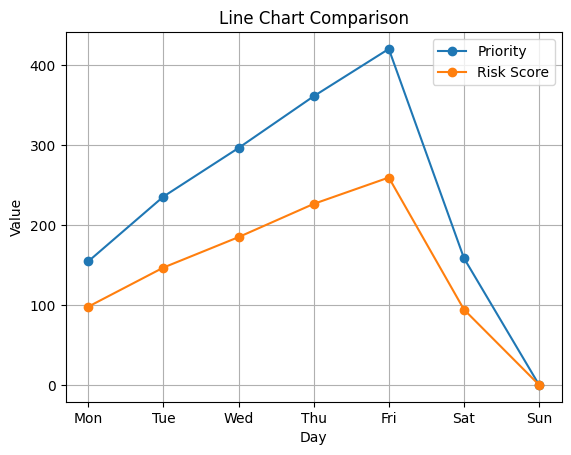

In [77]:
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

plt.figure()
plt.plot(days, backlog_risk_priority, marker='o', label='Priority')
plt.plot(days, backlog_risk_slar, marker='o', label='Risk Score')

plt.xlabel("Day")
plt.ylabel("Value")
plt.title("Line Chart Comparison")
plt.legend()
plt.grid(True)

plt.show()


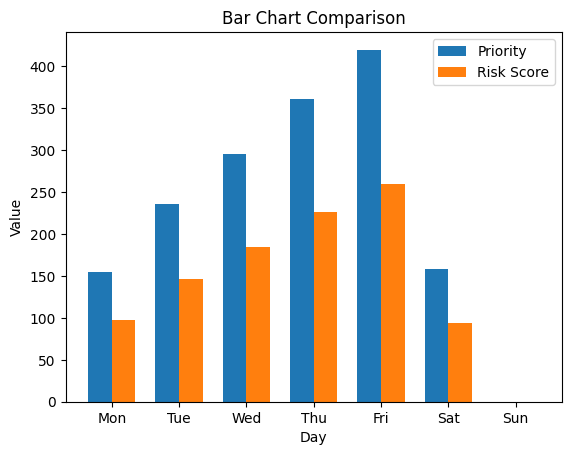

In [78]:
x = np.arange(len(days))
width = 0.35

plt.figure()
plt.bar(x - width/2, backlog_risk_priority, width, label='Priority')
plt.bar(x + width/2, backlog_risk_slar, width, label='Risk Score')

plt.xlabel("Day")
plt.ylabel("Value")
plt.title("Bar Chart Comparison")
plt.xticks(x, days)
plt.legend()

plt.show()


In [79]:
sum_diff = np.array(backlog_risk_priority) - np.array(backlog_risk_slar)
perc_difference = (sum_diff/np.array(backlog_risk_priority))*100
perc_difference[-1] = 0
np.average(perc_difference)

C:\Users\VISHNU\AppData\Local\Temp\ipykernel_2384\365637472.py:2: RuntimeWarning: invalid value encountered in divide
  perc_difference = (sum_diff/np.array(backlog_risk_priority))*100


np.float64(32.58038548978419)

In [80]:
total_risk = []
for data in weekly_dataframes:
    temp = sum(data['SLA_Risk_Score'])
    total_risk.append(temp)

In [81]:
df = pd.DataFrame({
    'day': days,
    'risk_priority': backlog_risk_priority,
    'risk_sla': backlog_risk_slar,
    'total_risk': total_risk
})

df.head()

,day,risk_priority,risk_sla,total_risk
0,Mon,154.296937,97.733628,846.298993
1,Tue,235.266346,146.610286,726.905674
2,Wed,296.028496,184.674218,699.851872
3,Thu,360.697887,226.196758,685.704172
4,Fri,419.860404,259.152333,683.922920


In [82]:
df.to_csv('Data/Processed/metrics_summary.csv')